* On utilise un réseau Unet pour la segmentation d'images sous marines             BL 29/05/2020
* On utilise la librairie Fastai basée sur pytorch, elle incorpore plusieurs fonctions déja construites
* le réseau est préentrainé sur imagenet et on entraine les dernières couches sur le dataset: suim_dataset
* article: Semantic Segmentation of Underwater Imagery: Dataset and Benchmark
* source dataset: Source: https://irvlab.cs.umn.edu/resources/usr-248-dataset
* paper: https://arxiv.org/pdf/2004.01241.pdf


RGB color code and object categories
* 000 BW: Background waterbody                    (black)---0
* 001 HD: Human divers                            (blue)----1
* 010 PF: Plants/sea-grass                        (green)---2
* 011 WR: Wrecks/ruins                            (cyan)----3
* 100 RO: Robots/instruments                      (red)-----4
* 101 RI: Reefs and invertebrates                 (Pink)----5
* 110 FV: Fish and vertebrates                    (yellow)--6
* 111 SR: Sand/sea-floor (& rocks)                (white)---7

In [1]:
# librairie fastai2 et sklearn

%matplotlib inline
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from nbdev.showdoc import *
from fastai2.vision.widgets import *

* Accès au fichiers, on utilise Pathlib 

In [2]:
# chemins pour les images et les masques

path_cur = Path.cwd()
print(path_cur)
print(path_cur.parent)
path_img = path_cur.parent/'storage/water_pics_withmask/train_val/images'
print(path_img)
path_lbl = path_cur.parent/'storage/water_pics_withmask/train_val/maskpng'
print(path_lbl)
path_data = path_cur.parent/'storage/water_pics_withmask/train_val'
print(path_data)
path_test = path_cur.parent/'storage/water_pics_withmask/test'
print(path_test)

/notebooks/notebook_undewater
/notebooks
/notebooks/storage/water_pics_withmask/train_val/images
/notebooks/storage/water_pics_withmask/train_val/maskpng
/notebooks/storage/water_pics_withmask/train_val
/notebooks/storage/water_pics_withmask/test


In [3]:
# on compte le nombre d'image et de masques

import collections
number_images = collections.Counter(p.suffix for p in path_img.iterdir())
number_mask = collections.Counter(p.suffix for p in path_lbl.iterdir())
print(f'# images: {number_images}, # mask: {number_mask}')

# images: Counter({'.jpg': 1525}), # mask: Counter({'.png': 1525})


In [4]:
fnames_test = get_image_files(path_test)

In [20]:
# données

fnames = get_image_files(path_img)            # images
lbl_names = get_image_files(path_lbl)         # mask
print(fnames[0:3])                           
print(lbl_names[0:3])

(#3) [Path('/notebooks/storage/water_pics_withmask/train_val/images/n_l_34_.jpg'),Path('/notebooks/storage/water_pics_withmask/train_val/images/f_r_521_.jpg'),Path('/notebooks/storage/water_pics_withmask/train_val/images/f_r_200_.jpg')]
(#3) [Path('/notebooks/storage/water_pics_withmask/train_val/maskpng/f_r_166_P.png'),Path('/notebooks/storage/water_pics_withmask/train_val/maskpng/d_r_674_P.png'),Path('/notebooks/storage/water_pics_withmask/train_val/maskpng/f_r_200_P.png')]


In [21]:
# format d'une image (RGB) et d'un mask

img_f = fnames[0]
print(type(img_f))
img = PILImage.create(img_f)
print(f'image shape:\n{tensor(img).shape}')

# fonction pour trouver le mask associé
get_y_fn = lambda x: path_lbl/f'{x.stem}P.png'

mask_f = get_y_fn(img_f)
mask = PILMask.create(mask_f)
print(f'mask shape:\n{mask.shape}')

<class 'pathlib.PosixPath'>
image shape:
torch.Size([540, 960, 3])
mask shape:
(540, 960)


In [23]:
??PILBase

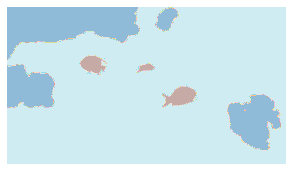

In [6]:
mask.show()

In [7]:
# un masque
src = tensor(mask)
print(src.unique())
print(src)

tensor([5, 6, 7], dtype=torch.uint8)
tensor([[5, 5, 5,  ..., 7, 7, 7],
        [5, 5, 5,  ..., 7, 7, 7],
        [5, 5, 5,  ..., 7, 7, 7],
        ...,
        [7, 7, 7,  ..., 7, 7, 7],
        [7, 7, 7,  ..., 7, 7, 7],
        [7, 7, 7,  ..., 7, 7, 7]], dtype=torch.uint8)


In [19]:
??PILBase

In [6]:
# on prend une série d'images avec les masques associés

n1, n2 = 0, 10
images_files = [fnames[n1+i] for i in range(n1+n2)]
masks_files = list(map(get_y_fn,images_files))

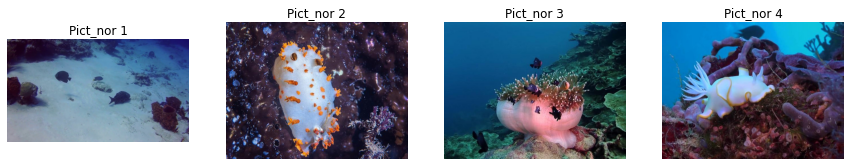

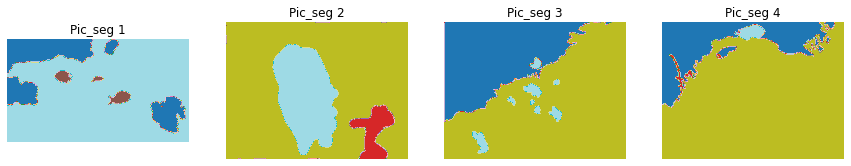

In [9]:
# plot d'images et masques associés

_,axs = plt.subplots(1,4,figsize=(15,15))
for i,ax in enumerate(axs): 
    img_f = fnames[i]
    img = PILImage.create(img_f)
    img.show(ax=ax, title=f'Pict_nor {i+1}')

_,axs = plt.subplots(1,4,figsize=(15,15))
for i,ax in enumerate(axs): 
    img_f = fnames[i]
    mask = PILMask.create(get_y_fn(img_f))
    mask.show(ax=ax, title=f'Pic_seg {i+1}', alpha=1) 

In [8]:
# codes masks
# bw: Background waterbody
# hd: Human divers
# pf: auquatic plants/sea grass
# wr: wrecks/ruins
# ro: robots/instruments
# ri: reefs/invertebrates
# fv: fish and vertebrates
# sr: sand/ sea floor and rocks

codes = ['background', 'human_diver', 'aquatic_plants', 'wreck_ruins',
          'robots_instruments', 'reefs_invertebrates', 'fish_vertebrates',
         'sand_sea_floor_rocks']

codes = np.array(codes, dtype = str)
print(f'number of classes labels:{len(codes)}')

number of classes labels:8


In [9]:
# cette function permet d'extraire le mask associée à l'image correspondante
def label_func(fn): return path_data/'maskpng'/f'{fn.stem}P.png'

test1 = label_func(fnames[0])
print(fnames[0])
print(test1)

/notebooks/storage/water_pics_withmask/train_val/images/n_l_34_.jpg
/notebooks/storage/water_pics_withmask/train_val/maskpng/n_l_34_P.png


In [10]:
# Datablock - Dataloader - class définit par fastai

# on définit un datablock en répondant aux questions suivantes:
# 1. type d'entrées et cibles: Images et mask
# 2. Ou sont les images: dans les répertoires
# 3. séparation train et valid set: random split (80 % pour le train et 20 % pour le validation set)
# 4. comment trouver le label associé à une image: en regardant le fichier correspondant dans le répertoire maskpng
# 5. après que le batch soit crée on applique data augmentation

def get_dls(bs, size,codes):
    data_img = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),  
                   get_items=get_image_files,                               # sources                          
                   splitter = RandomSplitter(seed=42),                      # split train/valid
                   get_y= label_func,                                       # associated y target (dependant variable)
                   item_tfms=Resize(size),                                   
                   batch_tfms=[*aug_transforms(size=size), Normalize.from_stats(*imagenet_stats)]) 
                                                                            # series de transformations et normalisation
    #print(data_img.summary(path_data/'images'))
    
    return data_img.dataloaders(path_data/"images", bs=bs)

In [11]:
??get_image_files

In [20]:
bs = 8                            # batch_size
                                  # on commence petit 
size = (240, 320)
size2 = (480, 640)
dls = get_dls(bs=bs, size = size, codes = codes)
print(f'train set size: {len(dls.train_ds)}, valid set size:{len(dls.valid_ds)}')
print(f'batch train size: {len(dls.train)}, valid batch size:{len(dls.valid)}')

train set size: 1220, valid set size:305
batch train size: 152, valid batch size:39


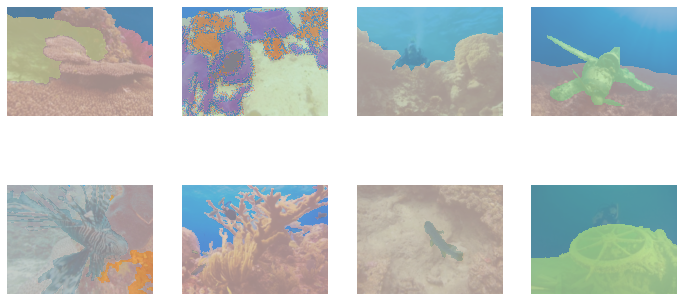

In [15]:
# image et mask superposé du train dataset
dls.show_batch(alpha = 0.5)
#show_at(dls.train_ds, 0, alpha = 0.5)  pour une image particulière

In [16]:
xb, yb = dls.train.one_batch()
print(f'xb: {xb.shape}, yb: {yb.shape}')
# En entrée du modèle: 8 images de couleur de format 160*120.
# le vecteur dépendant  contient les masques. tenseur 2D contenant les 8 classes de 0 à 7
# batch_size = 8

xb: torch.Size([8, 3, 240, 320]), yb: torch.Size([8, 240, 320])


In [11]:
print(codes)

# label correspondant au classes
name2id = {v:k for k,v in enumerate(codes)}
print(name2id)

['background' 'human_diver' 'aquatic_plants' 'wreck_ruins'
 'robots_instruments' 'reefs_invertebrates' 'fish_vertebrates'
 'sand_sea_floor_rocks']
{'background': 0, 'human_diver': 1, 'aquatic_plants': 2, 'wreck_ruins': 3, 'robots_instruments': 4, 'reefs_invertebrates': 5, 'fish_vertebrates': 6, 'sand_sea_floor_rocks': 7}


In [18]:
# Pour une classification à 5 éléments comme dans l'article, les classes 0, 2 et 7 sont regroupées
[name2id['background'], name2id['aquatic_plants'], name2id['sand_sea_floor_rocks']]

[0, 2, 7]

In [12]:
lbl_list = [name2id['human_diver'], name2id['wreck_ruins'],
            name2id['robots_instruments'], name2id['reefs_invertebrates'],
            name2id['fish_vertebrates']]
print(lbl_list)

[1, 3, 4, 5, 6]


* Metriques.

* Precision_c = nombre de pixel correctement prédit pour la classe c /nombre de pixel prédit pour la classe c
* Recall_c    = nombre de pixel correctement prédit pour la classe c / nombre de pixel appartenant à la classe c
* Precision_moyenne = somme(Precision_c)/ #classes
* Intersection of Union IoU ou Jaccard score  (A inter B) / (A union B).  pour chaque classe

In [13]:
dls.vocab = codes
dls.vocab

array(['background', 'human_diver', 'aquatic_plants', 'wreck_ruins',
       'robots_instruments', 'reefs_invertebrates', 'fish_vertebrates',
       'sand_sea_floor_rocks'], dtype='<U20')

In [13]:
# cette fonction calcul la précision moyenne: Nbre de pixel correctement prédit / nombre de pixel total

def acc_segment(input, target):
    """fonction pour calculer nombre de pixel correctement prédit/nombre de pixel total"""
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()   # argmax pour extraire la classe la plus probable
                                                          # la dim 1 du tensor contient les probabilités pour
                                                          # chaque classe
        
# cette fonction calcul la précision moyenne pour 5 classes restantes 
# HD, WR, RO, RI et FV.  le rest est considéré comme background
def acc_segment5(input, target):
    target = target.squeeze(1)               
    mask = (target != name2id['background'])\
    & (target != name2id['aquatic_plants'])\
    & (target != name2id['sand_sea_floor_rocks'])                        
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()  

In [14]:
# A faire ajouter les métriques F1 score et IoU
# avec la function F1scoreMulti et JaccardMulti de fastai
def iou(input, target):
    """fonction pour calculer l'intersection over union moyenne sur les classes"""
    list_iou = []
    target = target.squeeze(1)
    for i in target.unique():
        mask_target = target == i                # True for the ith label class False elsewhere  for target y 
        mask_input = input.argmax(dim=1) == i    # True for the ith label class False elsewhere  for the pred y 
        inter = (mask_target*mask_input).sum()
        union = (mask_target + mask_input).sum()
        iou = inter.item()/union.item()
        list_iou.append(iou)
        
    return (tensor(list_iou).float().mean())


In [15]:
def iou_check(input,target):
    eps = 1e-4
    list_iou = []
    target = target.squeeze(1)
    for i in target.unique():
        mask_target = target == i                # True for the ith label class False elsewhere  for target y 
        mask_input = input.argmax(dim=1) == i   
        inter = torch.dot(mask_target.view(-1), targe.view(-1))
        union = torch.sum(input) + torch.sum(target) + eps

In [16]:

def iou5(input, target):
    """fonction pour calculer l'intersection over union moyenne sur les 5 classes"""
    list_iou = []
    target = target.squeeze(1)
    lbl = target.unique()                   # les labels existant dans un mask donné
    lbl_list = [name2id['human_diver'], name2id['wreck_ruins'],
            name2id['robots_instruments'], name2id['reefs_invertebrates'],
            name2id['fish_vertebrates']]
    lbl_keep = list(filter(lambda x: x in lbl_list, lbl))  # on garde seulement les 5 labels qui nous intéressent
    eps = 1e-5
    for i in lbl_keep:                           # on calcule le IoU pour chaque classe
        
        mask_target = target == i                # True for the ith label class False elsewhere  for target y 
        mask_input = input.argmax(dim=1) == i    # True for the ith label class False elsewhere  for the pred y 
        inter = (mask_target*mask_input).sum()
        union = (mask_target + mask_input).sum()
        if (inter <= eps) or (union <= eps):
            iou = 0
        else:
            iou = inter.item()/union.item()
            list_iou.append(iou)
            
    return (tensor(list_iou).float().mean())

In [24]:
# exemple test
target = [0, 1, 2, 3, 4, 6]
lbl_list = [name2id['human_diver'], name2id['wreck_ruins'],
            name2id['robots_instruments'], name2id['reefs_invertebrates'],
            name2id['fish_vertebrates']]
lbl_keep = list(filter(lambda x: x in lbl_list, target))
print(lbl_list)
print(lbl_keep)

[1, 3, 4, 5, 6]
[1, 3, 4, 6]


In [17]:
def f1_5(input, target):
    """fonction pour calculer le f1 score moyenné sur les classes"""

    list_f1 = []
    target = target.squeeze(1)
    lbl = target.unique()
    lbl_list = [name2id['human_diver'], name2id['wreck_ruins'],
                name2id['robots_instruments'], name2id['reefs_invertebrates'],
                name2id['fish_vertebrates']]
    lbl_keep = list(filter(lambda x: x in lbl_list, lbl))
    eps = 1e-5
    for i in lbl_keep:
        mask_target = target == i                  # True for the ith label class False elsewhere  for target y 
        mask_input = input.argmax(dim=1) == i      # True for the ith label class False elsewhere  for the pred y 
        TP = (mask_target*mask_input).sum()        # labels correctement prédits, TP
        TP_FP = (mask_input).sum()                    # labels prédits 
        TP_FN = (mask_target).sum()                   # labels appartenant à la bonne classe
        
        if TP <= eps:                              # si pas de TP, prec = rec = f1 = 0
            prec = eps
            rec = eps
        else:
            prec = TP.item()/ TP_FP.item()
            rec = TP.item()/  TP_FN.item()

            
        f1 = 2*prec*rec/(prec+rec)
        list_f1.append(f1)
    
    return (tensor(list_f1).float().mean())

In [26]:
?JaccardCoeff

In [21]:
# on definit le modèle , architecture basée sur resnet34 
learn = unet_learner(dls, resnet34, metrics=[acc_segment,acc_segment5,foreground_acc,iou,iou5, f1_5])

In [28]:
learn.summary()

DynamicUnet (Input shape: ['8 x 3 x 240 x 320'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               8 x 64 x 120 x 160   9,408      False     
________________________________________________________________
BatchNorm2d          8 x 64 x 120 x 160   128        True      
________________________________________________________________
ReLU                 8 x 64 x 120 x 160   0          False     
________________________________________________________________
MaxPool2d            8 x 64 x 60 x 80     0          False     
________________________________________________________________
Conv2d               8 x 64 x 60 x 80     36,864     False     
________________________________________________________________
BatchNorm2d          8 x 64 x 60 x 80     128        True      
________________________________________________________________
ReLU                 8 x 64 x 60 x 80     0          False     
_________________________________________________

In [107]:
learn.loss_func            # same as crossentropyloss, but input and target are flatten

FlattenedLoss of CrossEntropyLoss()

(0.0003019951749593019, 0.00013182566908653826)

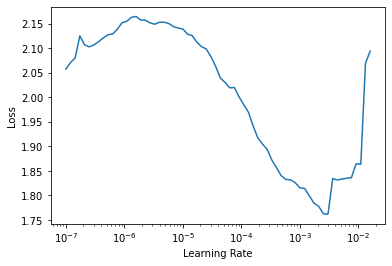

In [29]:
# fonction pour trouver un bon learning rate
learn.lr_find()

In [34]:
# on entraine avec 12 epochs. Les métriques sont toujours calculés par défaut sur le validation set
wd = 1e-2
lr = 2e-4
learn.fit_one_cycle(12, slice(lr), pct_start=0.9, wd=wd)   

epoch,train_loss,valid_loss,acc_segment,acc_segment5,foreground_acc,iou,iou5,f1_5,time
0,1.389894,1.218356,0.597090,0.573329,0.452700,0.175684,0.198659,0.172477,00:58
1,1.125968,0.971386,0.683318,0.680473,0.623734,0.305190,0.371210,0.351398,00:58
2,0.987544,0.876561,0.721943,0.716832,0.631834,0.376679,0.432527,0.499380,00:58
3,0.919082,0.873157,0.728981,0.814403,0.710054,0.380938,0.444078,0.491323,00:59
4,0.840583,0.780417,0.763077,0.770351,0.714007,0.430400,0.493385,0.547602,00:58
5,0.914832,0.833417,0.748698,0.819300,0.724941,0.425160,0.499928,0.558671,00:58
6,0.849390,0.746762,0.767051,0.768588,0.694976,0.446552,0.538576,0.580314,00:58
7,0.830374,0.860728,0.747733,0.797815,0.710828,0.433306,0.505889,0.567699,00:59
8,0.803747,0.818460,0.732470,0.835487,0.657378,0.394772,0.479496,0.555573,00:58
9,0.763978,0.779133,0.760257,0.723871,0.682778,0.437639,0.498274,0.564241,00:58


In [35]:
# on sauvegarde le modèle et ses poids
learn.save('res34_stage1')

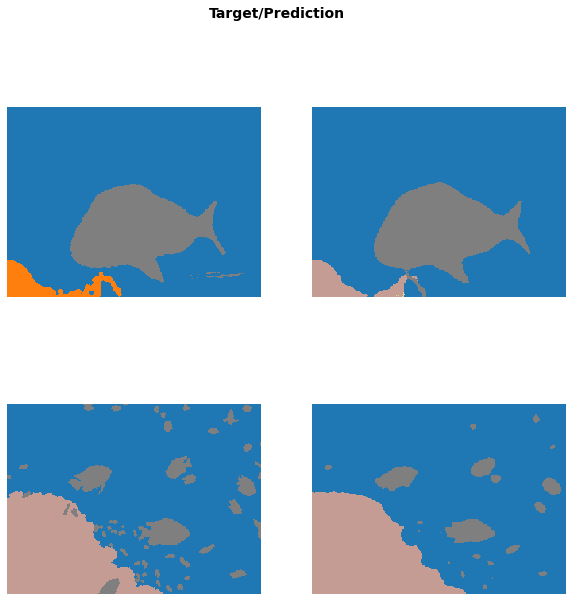

In [48]:
learn.show_results(ds_idx=0,max_n=8, figsize=(10,10), alpha = 1, shuffle = False)

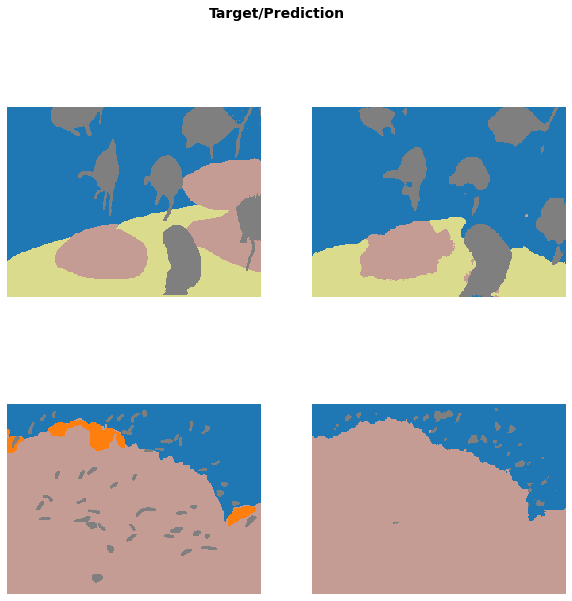

In [50]:
learn.show_results(ds_idx=1, max_n=8, figsize=(10,10), alpha = 1, shuffle = False)

In [51]:
learn.load('res34_stage1')

In [52]:
# on continue l'entrainement, mais avec des images plus grandes, 
# on réduit le batch_size de 8 à 4 (pour la mémoire)
lrs = slice(1e-6,lr/10)
learn.unfreeze()
learn.fit_one_show_at(dls.valid_ds, 10, alpha = 0.8)cycle(10, lrs)
#learn.fine_tune(15, 1e-3)

epoch,train_loss,valid_loss,acc_segment,acc_segment5,foreground_acc,iou,iou5,f1_5,time
0,0.596255,0.638708,0.801675,0.839679,0.759854,0.501916,0.587364,0.641211,01:02
1,0.588806,0.636700,0.799744,0.817513,0.754334,0.501940,0.578884,0.639737,01:02
2,0.587580,0.646157,0.801019,0.839679,0.754128,0.502669,0.576261,0.644544,01:02
3,0.591957,0.635311,0.801819,0.837099,0.762569,0.505572,0.584230,0.644727,01:02
4,0.543199,0.643370,0.800093,0.818228,0.759384,0.504206,0.577533,0.642123,01:02
5,0.522824,0.637168,0.803462,0.841354,0.759864,0.505871,0.591294,0.647679,01:01
6,0.510424,0.645115,0.800397,0.823633,0.755882,0.506364,0.574735,0.648716,01:02
7,0.511602,0.633399,0.803803,0.837547,0.761282,0.510660,0.581562,0.655170,01:02
8,0.505728,0.642246,0.803746,0.831625,0.756754,0.510179,0.584421,0.654664,01:02
9,0.506271,0.639476,0.803235,0.831721,0.760379,0.511443,0.582667,0.656326,01:02


In [43]:
# to continue
learn.save('res34_pic320_stage2')

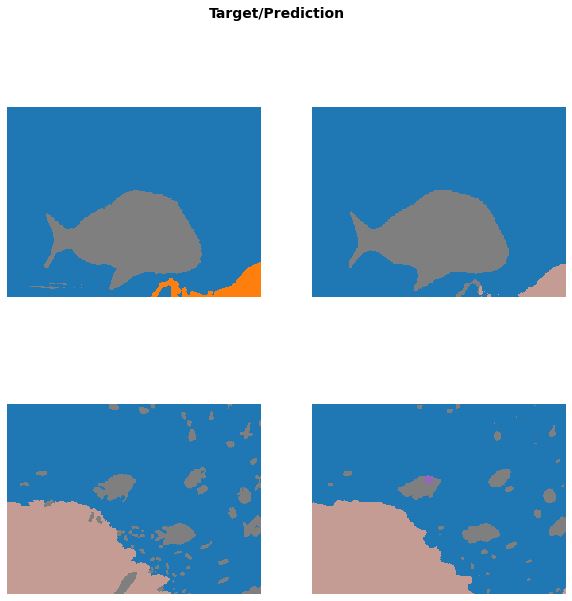

In [53]:
learn.show_results(ds_idx=0,max_n=8, figsize=(10,10), alpha = 1, shuffle = False)

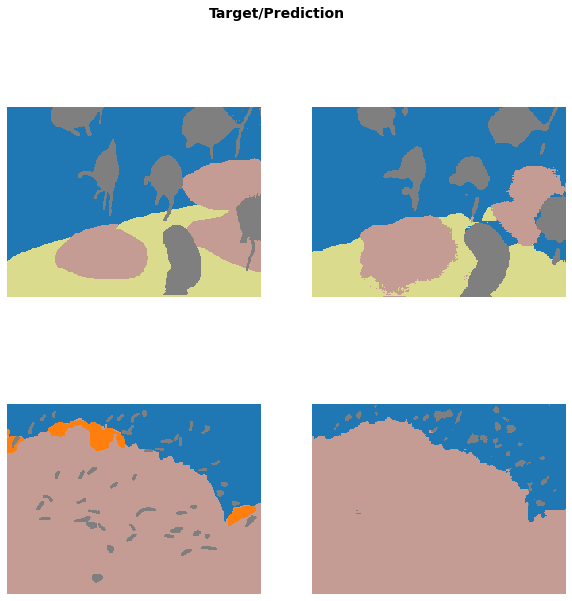

In [54]:
learn.show_results(ds_idx=1,max_n=8, figsize=(10,10), alpha = 1, shuffle = False)

In [55]:
# on augmente la taille de l'image et on réduit le batch_size de 4 à 3 (pour la mémoire)
learn.unfreeze()
learn.dls = get_dls(bs=4, size = (480,640), codes = codes)
learn.fine_tune(15, 1e-3)

epoch,train_loss,valid_loss,acc_segment,acc_segment5,foreground_acc,iou,iou5,f1_5,time
0,1.106074,1.074319,0.646476,0.650596,0.536119,0.286459,0.326245,0.322329,03:55


epoch,train_loss,valid_loss,acc_segment,acc_segment5,foreground_acc,iou,iou5,f1_5,time
0,0.832586,0.751963,0.773072,0.815690,0.702721,0.487017,0.547111,0.632056,03:55
1,0.722741,0.724676,0.779612,0.823043,0.708810,0.503503,0.587599,0.661895,03:54
2,0.828285,0.815969,0.738244,0.836931,0.689670,0.450453,0.545291,0.604443,03:54
3,0.805082,0.713624,0.785536,0.855876,0.741409,0.515989,0.586248,0.662456,03:54
4,0.758443,0.743193,0.784900,0.851661,0.732523,0.499409,0.592674,0.643485,03:54
5,0.702287,0.703544,0.783095,0.852954,0.737206,0.523171,0.607865,0.679165,03:54
6,0.701052,0.663560,0.800117,0.823722,0.750722,0.546411,0.603994,0.686920,03:53
7,0.648838,0.645109,0.807369,0.844841,0.755841,0.548331,0.624958,0.686852,03:53
8,0.613365,0.657318,0.807584,0.846043,0.763767,0.551781,0.612974,0.688735,03:53
9,0.566720,0.635773,0.811142,0.811262,0.754051,0.572430,0.634512,0.706636,03:53


In [56]:
# to be continuded
learn.save('res34_pic640_stage1')

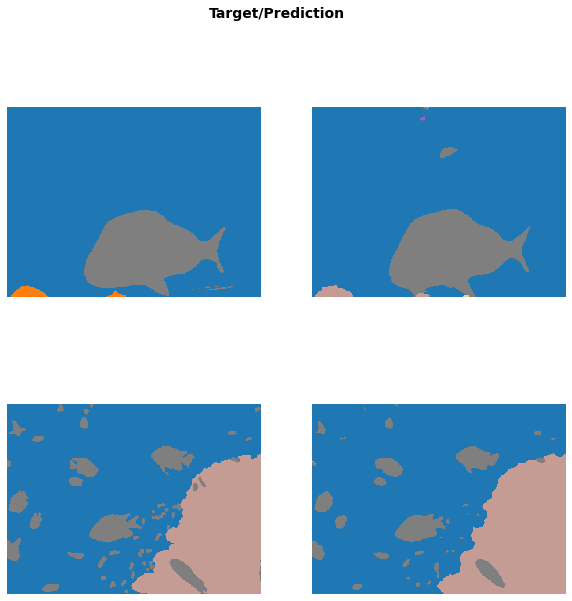

In [57]:
learn.show_results(ds_idx=0,max_n=8, figsize=(10,10), alpha = 1, shuffle = False)

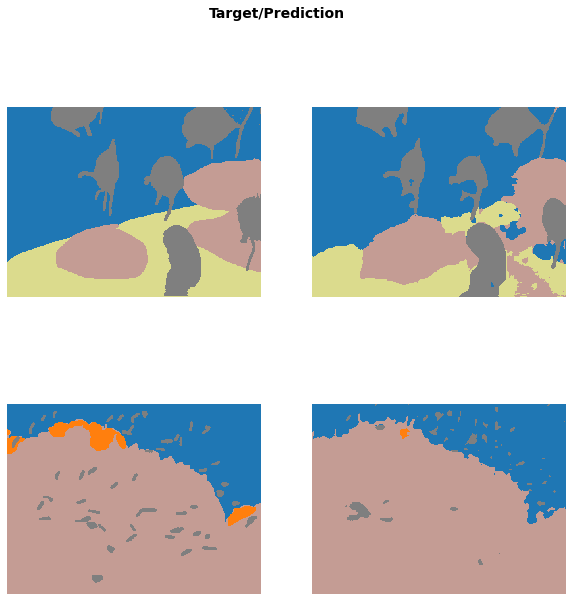

In [58]:
learn.show_results(ds_idx=1,max_n=8, figsize=(10,10), alpha = 1, shuffle = False)

In [22]:
learn.dls = get_dls(bs=4, size = (480,640), codes = codes)
learn.load('res34_pic640_stage1')

In [26]:
print(480*1.2)
print(640*1.2)

576.0
768.0


In [27]:
learn.dls = get_dls(bs=4, size = (576,768), codes = codes)
learn.fine_tune(15, 1e-3)

epoch,train_loss,valid_loss,acc_segment,acc_segment5,foreground_acc,iou,iou5,f1_5,time
0,0.656299,0.746894,0.796854,0.866072,0.781849,0.542457,0.616069,0.689434,05:26


epoch,train_loss,valid_loss,acc_segment,acc_segment5,foreground_acc,iou,iou5,f1_5,time
0,0.464858,0.604623,0.821785,0.855298,0.777861,0.589526,0.666009,0.735181,05:30
1,0.487576,0.626267,0.811228,0.817888,0.770400,0.579366,0.655275,0.725592,05:29
2,0.540830,0.600407,0.821519,0.838929,0.775135,0.581353,0.652115,0.719519,05:29
3,0.541083,0.651054,0.800063,0.787368,0.737189,0.561438,0.639849,0.707305,05:29
4,0.556836,0.783485,0.799465,0.845483,0.752086,0.545405,0.612312,0.691229,05:29
5,0.535788,0.645241,0.819506,0.843546,0.773195,0.585488,0.655719,0.727028,05:29
6,0.505553,0.664887,0.816404,0.838730,0.768958,0.576599,0.646169,0.713379,05:30
7,0.489963,0.625441,0.814131,0.826259,0.769447,0.584108,0.651158,0.718303,05:30
8,0.426649,0.617619,0.820292,0.857686,0.774994,0.595204,0.665382,0.739948,05:30
9,0.387861,0.633742,0.819184,0.830456,0.775396,0.601288,0.669508,0.739283,05:30


In [31]:
learn.save('resnet34_576_768_stage_1')

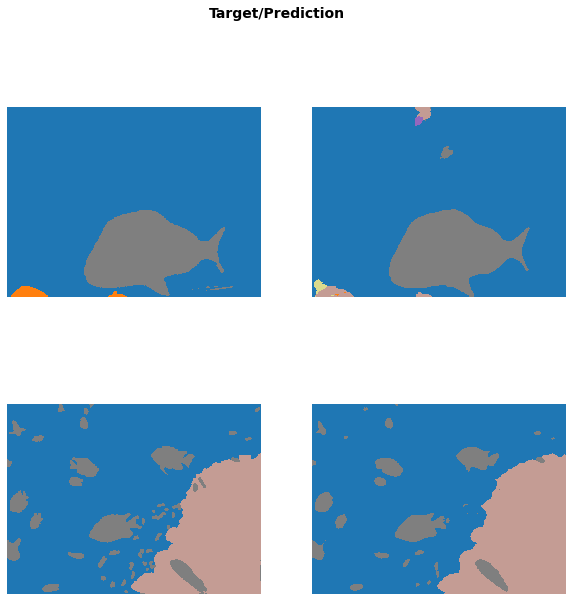

In [28]:
learn.show_results(ds_idx=0,max_n=8, figsize=(10,10), alpha = 1, shuffle = False)

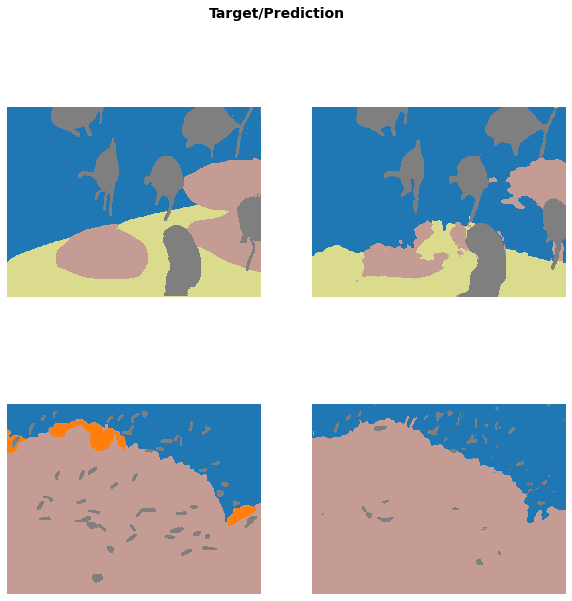

In [30]:
learn.show_results(ds_idx=1,max_n=8, figsize=(10,10), alpha = 1, shuffle = False)

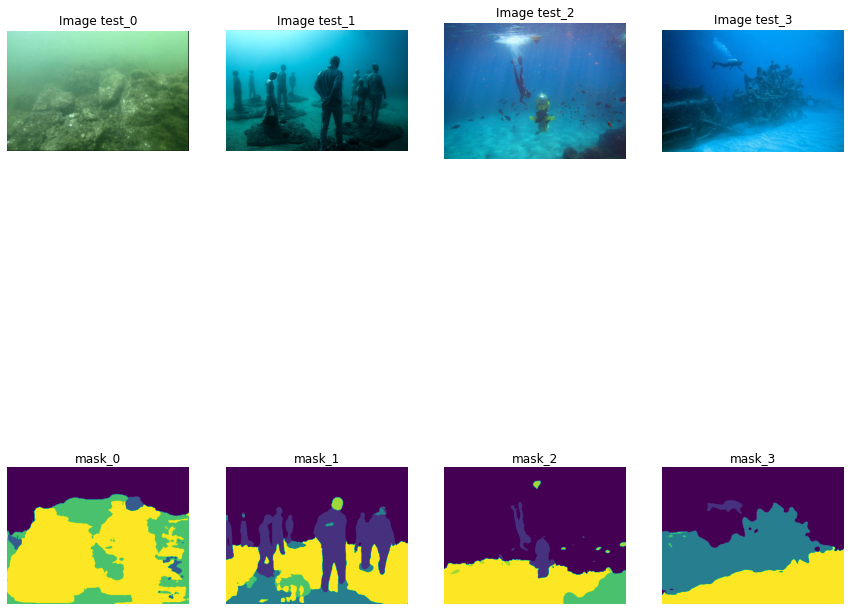

In [78]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 15))
ncols = 4
for col in range(ncols):
    ax[0,col].imshow(PILImage.create(fnames_test[col]))
    ax[0,col].set_title(f'Image test_{col}')
    ax[0,col].axis('off')   

for col in range(ncols):    
    ax[1,col].imshow(list_pred[col])
    ax[1,col].set_title(f'mask_{col}')
    ax[1,col].axis('off')

In [42]:
def plot_pred(files,n1=0,n2=10):
    list_pred = []

    dl = learn.dls.test_dl(files[n1:n2])
    preds = learn.get_preds(dl=dl)
    for i in range(n1,n2):
        pred_arx = preds[0][i].argmax(dim=0)
        list_pred.append(pred_arx)
    return list_pred

list_pred = plot_pred(files = fnames_test,n1=0,n2=10)

In [79]:
dict_map = {}
count = 0
for i in range(2):
    for j in range(2):
        for k in range(2):
            tuple = (i,j,k)
            dict_map.update({tuple: count})
            count = count + 1
print(dict_map)
int_to_tuple = {v:k for k, v in dict_map.items()}
print(int_to_tuple)

{(0, 0, 0): 0, (0, 0, 1): 1, (0, 1, 0): 2, (0, 1, 1): 3, (1, 0, 0): 4, (1, 0, 1): 5, (1, 1, 0): 6, (1, 1, 1): 7}
{0: (0, 0, 0), 1: (0, 0, 1), 2: (0, 1, 0), 3: (0, 1, 1), 4: (1, 0, 0), 5: (1, 0, 1), 6: (1, 1, 0), 7: (1, 1, 1)}


In [80]:
# fonction pour transformer un mask 2D avec label en une image rgb 3D
def mask2d_to_rgb(mask2d):
    """fonction qui transforme le mask 2d end tensor rgb"""
    array = np.zeros((*mask2d.shape, 3), dtype = np.uint8)
    for r in range(mask2d.shape[0]):
        for c in range(mask2d.shape[1]):
            for v in int_to_tuple.keys():
                if mask2d[r,c]  == v:
                    array[r,c,:] = int_to_tuple[v]
                    
    array = array*255
    image_rgb = Image.fromarray(array, 'RGB')
                    
    return image_rgb

In [81]:
def predict_mask(image):
    pred_mask = learn.predict(image)
    return mask2d_to_rgb(pred_mask[0])

In [82]:
list_predmask = [mask2d_to_rgb(e) for e in list_pred]

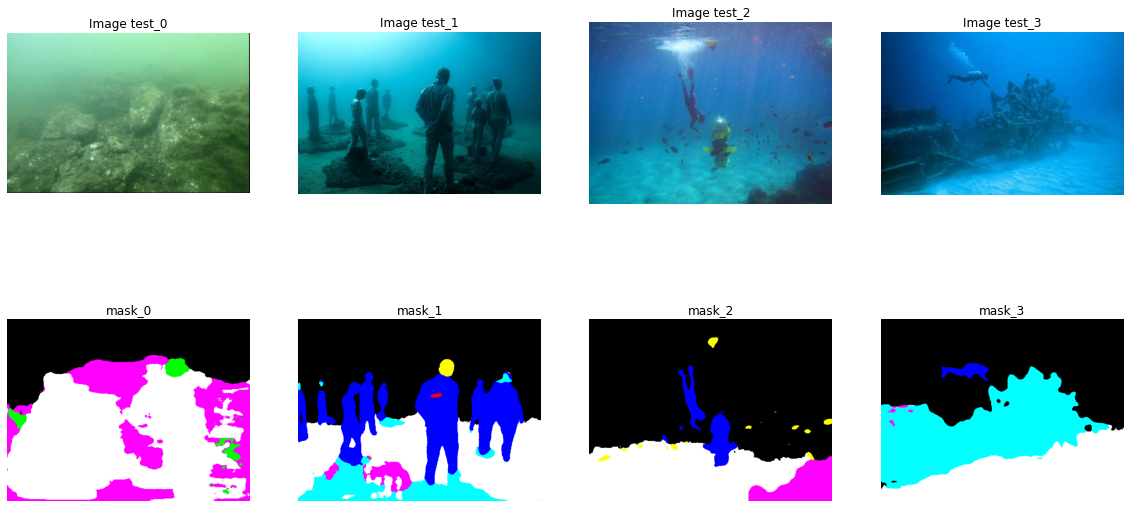

In [83]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
ncols = 4
for col in range(ncols):
    ax[0,col].imshow(PILImage.create(fnames_test[col]))
    ax[0,col].set_title(f'Image test_{col}')
    ax[0,col].axis('off')   

for col in range(ncols):    
    ax[1,col].imshow(list_predmask[col])
    ax[1,col].set_title(f'mask_{col}')
    ax[1,col].axis('off')
